# 序章

## ライブラリ・コマンドの準備

In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 初期設定

In [2]:
# 初期設定

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# warning表示off
import warnings
warnings.simplefilter('ignore')

In [3]:
# デバイスの割り当て (8章)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [51]:
# # 共通関数の読み込み (9章)

# # 共通関数のダウンロード
# !git clone https://github.com/makaishi2/pythonlibs.git

# # 共通関数のロード
# from pythonlibs.torch_lib1 import *

# # 共通関数の存在チェック
# print(README)

## 学習データ読み込み

In [4]:
# 学習用データの取り込み (12章)

# 学習用イメージのダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 学習用イメージの展開
w = !unzip dog_wolf.zip
print(w[-1])
 # ディレクトリ名の設定
data_dir = 'dog_wolf'

# ディレクトリ名設定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# 分類先クラス名設定
classes = ['dog', 'wolf']

# 解凍結果のツリー表示
!tree dog_wolf

2024-10-01 06:37:03 (8.02 MB/s) - ‘dog_wolf.zip.1’ saved [21811374/21811374]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
       

In [5]:
# 学習用データの準備 (8章、10章、12章)

# transformの定義
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

# datasetの定義
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# dataloaderの定義
batch_size = 5
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)


## 学習データのイメージ表示

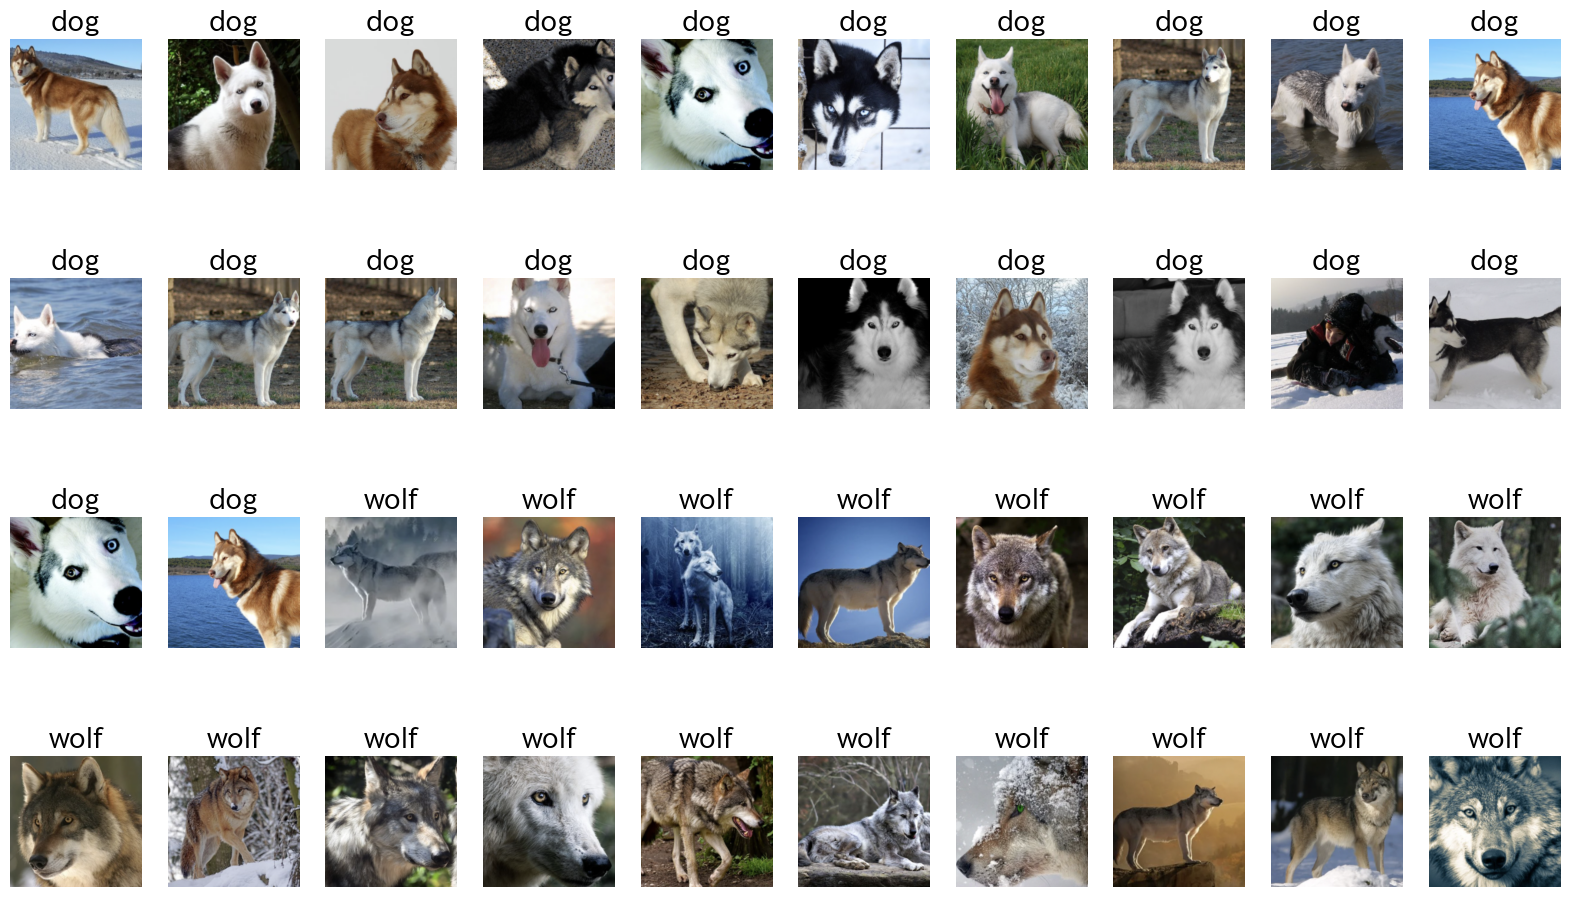

In [8]:
# 学習用データ(４0件)
show_images_labels(train_loader2, classes, None, None)

## 検証データのイメージ表示

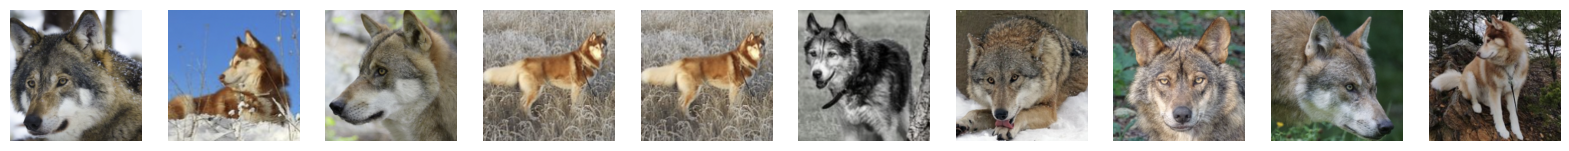

In [9]:
# 検証用データ(10件)
# 最初に正解なしでイメージのみ表示します。
# それぞれの写真がイヌかオオカミか、各自判断してみて下さい。
torch_seed()
show_images_labels(test_loader2, ['', ''], None, None)

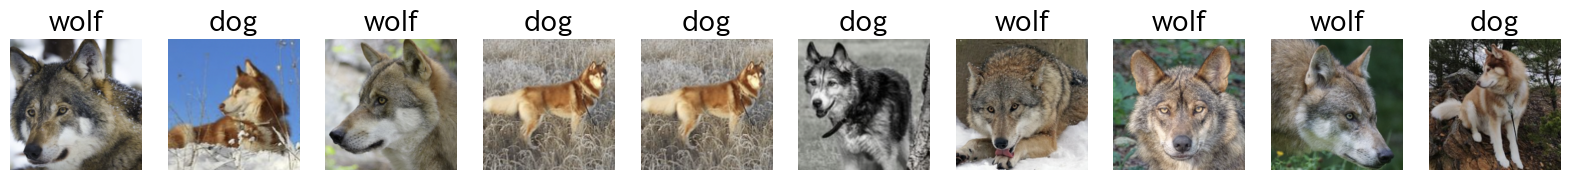

In [10]:
# 検証用データ(10件)
# こちらが正解データです。
# 10件中何件正解できたでしょうか？
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## モデル構築

In [30]:
# 事前学習済みモデルを利用したモデル構築 (11章)

# 事前学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 転移学習のためrequired_gradフラグをFalseにする
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義

# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [49]:
# 学習の実行 (9章)

# 繰り返し回数
num_epochs = 10

# 学習(共通関数)
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Epoch [1/10], loss: 0.46636 acc: 0.80952 val_loss: 0.24500, val_acc: 1.00000
Epoch [2/10], loss: 0.17724 acc: 0.97619 val_loss: 0.31807, val_acc: 0.81818
Epoch [3/10], loss: 0.15887 acc: 0.95238 val_loss: 0.17015, val_acc: 1.00000
Epoch [4/10], loss: 0.13764 acc: 0.97619 val_loss: 0.29767, val_acc: 0.81818
Epoch [5/10], loss: 0.14566 acc: 0.90476 val_loss: 0.21610, val_acc: 1.00000
Epoch [6/10], loss: 0.13124 acc: 0.95238 val_loss: 0.15908, val_acc: 1.00000
Epoch [7/10], loss: 0.07079 acc: 1.00000 val_loss: 0.23267, val_acc: 0.81818
Epoch [8/10], loss: 0.10959 acc: 0.95238 val_loss: 0.27705, val_acc: 0.81818
Epoch [9/10], loss: 0.03919 acc: 1.00000 val_loss: 0.42264, val_acc: 0.72727
Epoch [10/10], loss: 0.12147 acc: 0.95238 val_loss: 0.30524, val_acc: 0.81818


## 結果確認

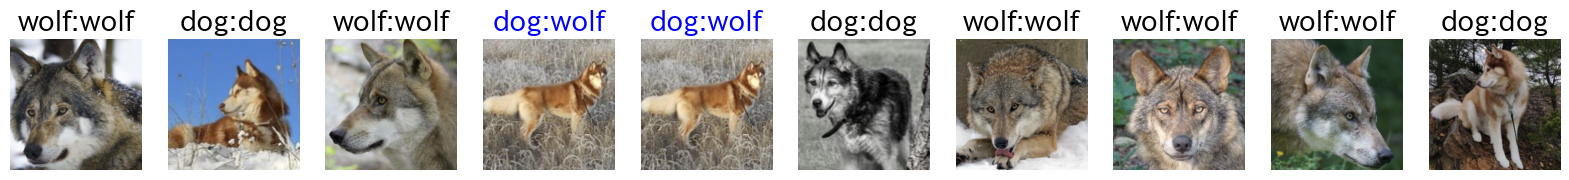

In [50]:
# 検証データを対象とした結果確認 (9章　共通関数)
torch_seed()
show_images_labels(test_loader2, classes, net, device)

## (参考)　共通関数の中身

In [48]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    # from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size
    
            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size 
            n_train_acc += (predicted == labels).sum().item() 

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)
 
            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [28]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [29]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True